In [1]:
#  Install required packages

In [2]:
!pip install datasets

In [3]:
# Prepare dataset for fine tunning

In [4]:
from datasets import load_dataset_builder, load_dataset


# Load the ROCO dataset
ds_builder = load_dataset_builder("gaodrew/roco-65k-256px")
dataset = load_dataset("gaodrew/roco-65k-256px")
train_dataset = dataset['train']

In [5]:
from itertools import islice

size_of_subset = 100
# Select the first 100 elements
candidate_training_set = train_dataset[:size_of_subset]

print(candidate_training_set)

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x78DF90AFA980>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x78DF90548D00>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x78DF90548D60>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x78DF90548DF0>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x78DF90548E50>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x78DF90548EB0>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x78DF90548F10>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x78DF90548F70>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x78DF90548FD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x78DF90549060>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x78DF905490C0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x78DF90549120>, <PIL.Jp

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import sys


class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return size_of_subset

    def __getitem__(self, idx):
        image = self.dataset['image'][idx]
        text = self.dataset['text'][idx]

        if self.transform:
            image = self.transform(image)

        return image, text


# replicate grayscale images to 3 channels
class ReplicateGrayscale(object):
    def __call__(self, image):
        if image.mode == 'L':
            # replicate the single channel to have 3 channels
            image = image.convert('RGB')
        return image

# image transformations
common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# apply the custom transform only to grayscale images
transform = transforms.Compose([
    ReplicateGrayscale(),
    common_transform
])

# custom dataset
custom_dataset = CustomDataset(candidate_training_set, transform)

# data loader
batch_size = 5
data_loader = DataLoader(custom_dataset, batch_size=batch_size)


In [8]:
#  Load tex and image encoders and define the model and fine tune it based on a contrastive loss strategy

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from tqdm import tqdm


# Model definition
class ContrastiveModel(nn.Module):
    def __init__(self, text_encoder, image_encoder, embedding_size):
        super(ContrastiveModel, self).__init__()
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.fc_text = nn.Linear(in_features=embedding_size, out_features=embedding_size)
        self.fc_image = nn.Linear(in_features=28, out_features=embedding_size)

    def forward(self, text_input, image_input):
        text_embedding = self.text_encoder(**text_input).last_hidden_state[:, 0, :]
        image_embedding = self.image_encoder(image_input)

        return self.fc_text(text_embedding), self.fc_image(image_embedding)

# Using BioBERT as text encoder
text_encoder = AutoModel.from_pretrained("monologg/biobert_v1.1_pubmed")

# Load corresponded BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('monologg/biobert_v1.1_pubmed', do_lower_case=True)

# Using ResNet as an image encoder
image_encoder = models.resnet50(pretrained=True)
image_encoder = nn.Sequential(*list(image_encoder.children())[:-4])  # Remove the classification head

# Model instantiation
model = ContrastiveModel(text_encoder, image_encoder, embedding_size=768)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_cosine_similarities(text_embeddings, image_embedding):
    # Normalizing the embeddings
    text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
    image_embedding = F.normalize(image_embedding, p=2, dim=-1)
    similarities = torch.matmul(text_embeddings, image_embedding.t())

    return similarities


def triplet_margin_loss(text_embeddings, image_embeddings, margin=1.0):
    # assuming that the text_embeddings and the image_embeddings are batches of normalized embeddings
    batch_size = text_embeddings.size(0)

    # pairwise cosine similarities
    similarities = torch.matmul(text_embeddings, image_embeddings.t())

    # indices for positive pairs
    indices = torch.arange(batch_size)
    positive_pairs = torch.stack([indices, indices])

    # indices for negative pairs
    negative_pairs = torch.cartesian_prod(indices, indices).view(-1, 2)
    negative_pairs = negative_pairs[negative_pairs[:, 0] != negative_pairs[:, 1]]

    positive_similarities = similarities[positive_pairs[0], positive_pairs[1]]
    negative_similarities = similarities[negative_pairs[:, 0], negative_pairs[:, 1]]

    # Repeating positive similarities for each corresponding negative similarity
    repeated_positive_similarities = positive_similarities.repeat_interleave(len(negative_similarities)//len(positive_similarities))

    # triplet margin loss
    loss = torch.clamp(margin - repeated_positive_similarities + negative_similarities, min=0.0).mean()

    return loss


# loss values for plotting
losses = []
average_epoch_loss = 0.0

# Number of epochs for training
num_epochs = 3

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0  # loss for the current epoch

    for image_input, text_input in tqdm(data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_epoch_loss:.4f}", unit="batch"):

        optimizer.zero_grad()

        text_input = tokenizer(text_input, return_tensors='pt', padding=True, truncation=True)
        text_output, image_output = model(text_input, image_input)
        image_output = torch.mean(image_output, dim=(1, 2), keepdim=False)

        loss = triplet_margin_loss(text_output, image_output)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # average loss for the epoch
        average_epoch_loss = epoch_loss / len(data_loader)
        losses.append(average_epoch_loss)


Epoch 3/3, Average Loss: 1.0128: 100%|██████████| 20/20 [01:21<00:00,  4.08s/batch]


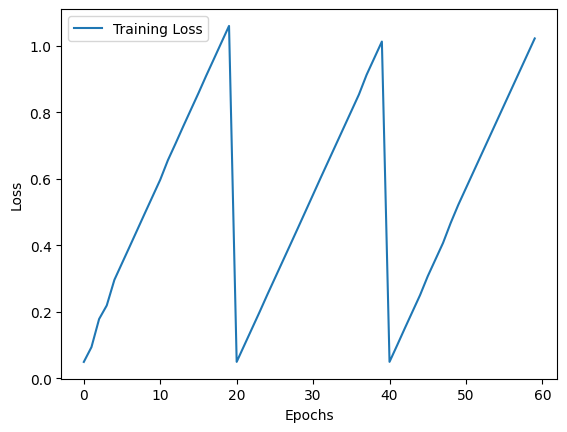

In [12]:
# training loss over epochs
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss_plot.png')

# Saving the trained model
torch.save(model.state_dict(), 'image_text_contrastive_training.pth')